In [1]:
import numpy as np, pandas as pd
import sys, os
import time, datetime
import random
import matplotlib.pyplot as plt
import pyomo.environ
from pyomo.core import *
from pyomo.opt import SolverFactory

# Checkout results of minority majority bias sim

In [2]:
def GDPC(eps, exact_counts):
        """ Geometric DP Counts
        Parameters
        ----------
        eps : float-able
        exact_counts : pd.Series
        
        Results
        -------
        returns dp_counts, a pd.Series with index matching exact_counts"""
        
        z = float(eps)

        all_errors = (np.random.geometric(z, size=len(exact_counts))
                        - np.random.geometric(z, size=len(exact_counts)))
        dp_counts = exact_counts + all_errors
        return dp_counts


In [3]:
def nonnegative_optimize(imprecise_counts, control_total):
    """optimize the imprecise counts so that they sum to
    the control total and are non-negative
    
    Parameters
    ----------
    imprecise_counts : list-like of floats
    control_total : float
    
    Results
    -------
    returns optimized_counts, which are close to imprecise counts,
    but not negative, and match control total in aggregate
    """
    imprecise_counts = list(imprecise_counts)
    
    model = ConcreteModel()
    model.I = range(len(imprecise_counts))
    model.x = Var(model.I, within=NonNegativeReals)
    model.objective = Objective(
        expr=sum((model.x[i] - imprecise_counts[i])**2 for i in model.I))
    model.constraint = Constraint(
        expr=summation(model.x) == control_total)
    
    solver = SolverFactory('ipopt')
    results = solver.solve(model, options={'acceptable_tol':1e-4}, tee=False)
    optimized_counts = [value(model.x[i]) for i in model.I]
        
    return np.array(optimized_counts)

In [25]:
def main(optimizer, a, b, pct_minority, segregation_factor, K, N, epsilon, seed):
    """ run full algorithm to add geometric noise then optimize to remove negatives
    over a population with minority and majority subpopulations
    for which the minority pop is in the majority in some "counties"
    
    Parameters
    ----------
    a,b = parameters of beta distribution for # individulas per county
    seg_factor = degree of segretation, county level
    pct_minority = pct of population in the minority
    K = total population size
    epsilon = parameter for amount of privacy in overall counts
    
    Output
    ------
    array with:
    which areas were originally minority majority, minority minority
    precise minority counts, precise majority counts
    dp minority counts, dp majority counts
    nn minority counts, nn majority counts
    """
    np.random.seed(seed)
    n_k = np.random.beta(a, b, K) # number of individuals in area k
    n_k *= N/sum(n_k)
    total_pop = sum(n_k)

    minority_share = np.random.beta(pct_minority/segregation_factor,
                                    (1-pct_minority)/segregation_factor, size=K)
    minmaj_area = minority_share >= 0.5
    minmin_area = minority_share < 0.5
    # simulate race-/location-stratified counts
    precise_minority_count = np.random.binomial(n_k.astype(int), minority_share)
    precise_majority_count = n_k - precise_minority_count

    # add Geometric noise, to make counts differentially private
    dp_minority_count = GDPC(epsilon, precise_minority_count)
    dp_majority_count = GDPC(epsilon, precise_majority_count)

    # optimize to find counts that are "close" to the dp counts,
    # are non-negative, and have race-stratified sums that match the precise
    # total sum for both minority and majority groups

    nn_minority_count = optimizer(dp_minority_count, precise_minority_count.sum())
    nn_majority_count = optimizer(dp_majority_count, precise_majority_count.sum())

    return[minmaj_area,minmin_area,
           precise_minority_count,precise_majority_count,
           dp_minority_count,dp_majority_count,
           nn_minority_count,nn_majority_count]

In [5]:
def see_minmaj_distr(main_obj, version, use_log = False):
    """ Plot minority counts
    
    Parameters
    ----------
    output array of "main"
    whether to use precise, dp, or nn counts
    whether to plot y axis on a log scale
    
    Output
    ------
    histogram of selected counts
    with total minority counts
    overlaid with the distribution of minority counts in previously minority majority areas
    """
    minmaj_area,minmin_area = main_obj[0], main_obj[1]
    if version=="precise":
        x1, x2 = 2,3
    elif version=="dp":
        x1, x2 = 4,5
    elif version=="nn":
        x1, x2 = 6,7
    else:
        raise Exception("oops; version must be in ['precise','dp','nn']")
    minority_count,majority_count = main_obj[x1], main_obj[x2]
    plt.hist(minority_count, bins=100)
    plt.hist(minority_count[minmaj_area], bins = 100, log = use_log)
    title = version + " minority count distribution; minority majority count redistribution"
    if use_log:
        title = "log scale: " + title
    plt.title(title)
    plt.show()
    plt.close()

In [6]:
def summaries(main_obj):
    """     
    Parameters
    ----------
    output array of "main"
    
    Output
    ------
    Table with summaries of total counts for
    {precise, dp, nn} x {minority majority areas, min min areas}
    """
    #grab outputs
    minmaj_area,minmin_area = main_obj[0], main_obj[1]
    precise_minority_count,precise_majority_count = main_obj[2], main_obj[3]
    dp_minority_count,dp_majority_count = main_obj[4], main_obj[5]
    nn_minority_count,nn_majority_count = main_obj[6], main_obj[7]
    
    # get stats
    minmaj_count, minmin_count = minmaj_area.sum(), minmin_area.sum()
    
    precise_total_minmaj, precise_mean_minmaj = precise_minority_count[minmaj_area].sum(), precise_minority_count[minmaj_area].sum()/minmaj_count
    dp_total_minmaj, dp_mean_minmaj = dp_minority_count[minmaj_area].sum(), dp_minority_count[minmaj_area].sum()/minmaj_count
    nn_total_minmaj, nn_mean_minmaj = nn_minority_count[minmaj_area].sum(), nn_minority_count[minmaj_area].sum()/minmaj_count
    minmaj_change = 1-(nn_total_minmaj/dp_total_minmaj)
    
    precise_total_minmin, precise_mean_minmin = precise_minority_count[minmin_area].sum(), precise_minority_count[minmin_area].sum()/minmin_count
    dp_total_minmin, dp_mean_minmin = dp_minority_count[minmin_area].sum(), dp_minority_count[minmin_area].sum()/minmin_count
    nn_total_minmin, nn_mean_minmin = nn_minority_count[minmin_area].sum(), nn_minority_count[minmin_area].sum()/minmin_count
    minmin_change = 1-(nn_total_minmin/dp_total_minmin)
    
    #compile table
    summary = pd.DataFrame(columns=['precise','dp ','non-neg','pct change'],
                           index=["minority majority totals","minority minority totals"],
                           data = [[precise_total_minmaj,dp_total_minmaj,nn_total_minmaj,minmaj_change],
                     [precise_total_minmin,dp_total_minmin,nn_total_minmin,minmin_change]])
    return summary.T

In [15]:
pop_3e3 = main(nonnegative_optimize, a=.02, b=10, pct_minority=.05, segregation_factor=1, K=10_000, N=3e3, epsilon=0.1, seed=1)
pop_3e5 = main(nonnegative_optimize, a=.02, b=10, pct_minority=.05, segregation_factor=1, K=10_000, N=3e5, epsilon=0.1, seed=1)
pop_3e7 = main(nonnegative_optimize, a=.02, b=10, pct_minority=.05, segregation_factor=1, K=10_000, N=3e7, epsilon=0.1, seed=1)

In [16]:
summaries(pop_3e3)

,minority majority totals,minority minority totals
precise,83.000000,58.000000
dp,467.000000,-1028.000000
non-neg,5.684216,135.315884
pct change,0.987828,1.131630


In [9]:
summaries(pop_3e5)

,minority majority totals,minority minority totals
precise,8600.000000,6720.000000
dp,8595.000000,4791.000000
non-neg,7995.706490,7324.293588
pct change,0.069726,-0.528761


In [10]:
summaries(pop_3e7)

,minority majority totals,minority minority totals
precise,745555.000000,629062.000000
dp,746119.000000,629519.000000
non-neg,744862.487047,629754.512953
pct change,0.001684,-0.000374


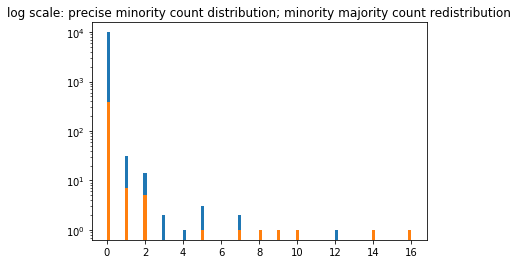

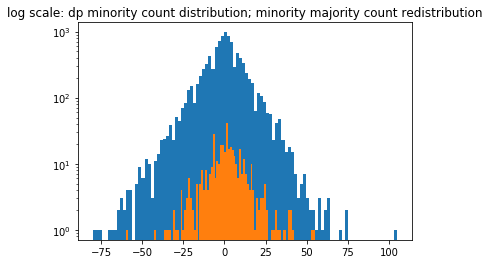

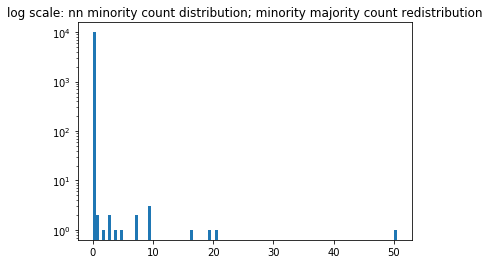

In [11]:
see_minmaj_distr(pop_3e3, version = "precise", use_log = True)
see_minmaj_distr(pop_3e3, version = "dp", use_log = True)
see_minmaj_distr(pop_3e3, version = "nn", use_log = True)

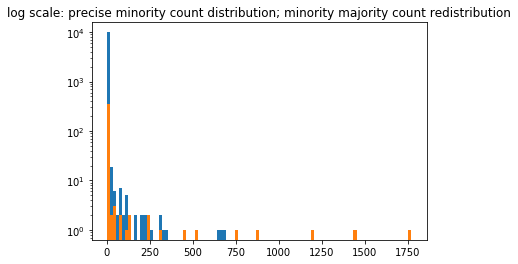

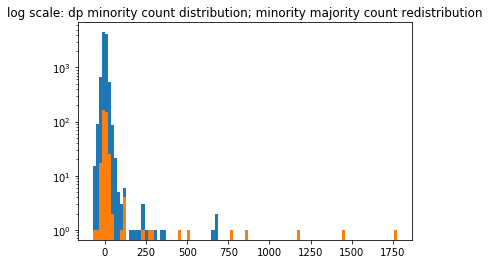

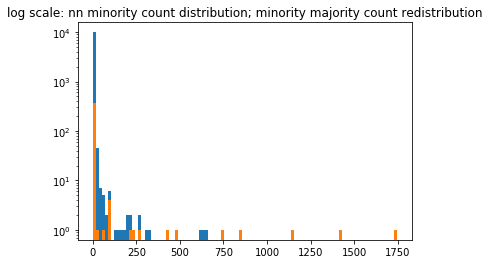

In [12]:
see_minmaj_distr(pop_3e5, version = "precise", use_log = True)
see_minmaj_distr(pop_3e5, version = "dp", use_log = True)
see_minmaj_distr(pop_3e5, version = "nn", use_log = True)

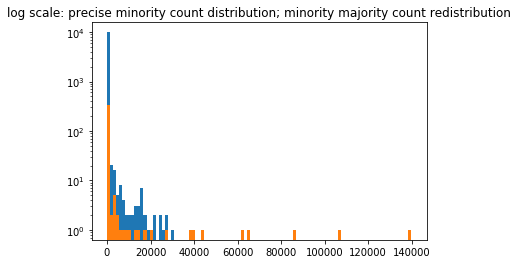

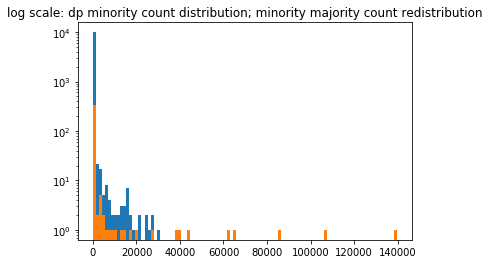

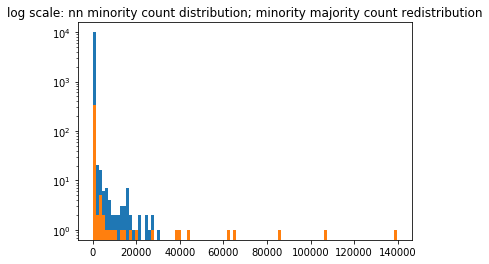

In [13]:
see_minmaj_distr(pop_3e7, version = "precise", use_log = True)
see_minmaj_distr(pop_3e7, version = "dp", use_log = True)
see_minmaj_distr(pop_3e7, version = "nn", use_log = True)

In [18]:
def nonnegative_optimize_mad(imprecise_counts, control_total):
    """optimize the imprecise counts so that they sum to
    the control total and are non-negative
    
    Parameters
    ----------
    imprecise_counts : list-like of floats
    control_total : float
    
    Results
    -------
    returns optimized_counts, which are close to imprecise counts,
    but not negative, and match control total in aggregate
    """
    imprecise_counts = list(imprecise_counts)
    
    model = ConcreteModel()
    model.I = range(len(imprecise_counts))
    model.x = Var(model.I, within=NonNegativeReals)
    model.objective = Objective(
        expr=sum(abs(model.x[i] - imprecise_counts[i]) for i in model.I))
    model.constraint = Constraint(
        expr=summation(model.x) == control_total)
    
    solver = SolverFactory('ipopt')
    results = solver.solve(model, options={'acceptable_tol':1e-4}, tee=False)
    optimized_counts = [value(model.x[i]) for i in model.I]
        
    return np.array(optimized_counts)

In [20]:
pop_3e3_mad = main(nonnegative_optimize_mad, a=.02, b=10, pct_minority=.05, segregation_factor=1, K=10_000, N=3e3, epsilon=0.1, seed=1)

    model=unknown;
        message from solver=Ipopt 3.12.13\x3a Maximum Number of Iterations
        Exceeded.


In [ ]:
summaries(pop_3e3_mad)

In [ ]:
summaries(pop_3e3)

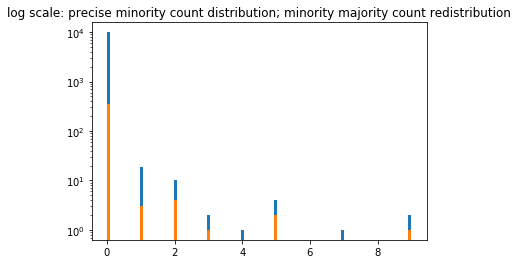

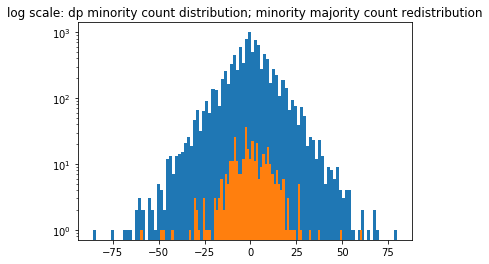

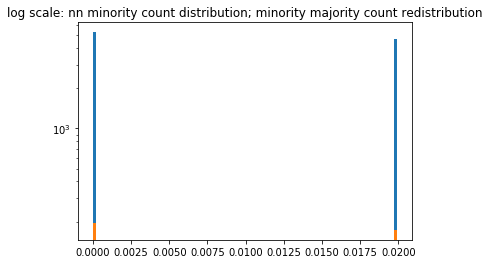

In [23]:
see_minmaj_distr(pop_3e3_mad, version = "precise", use_log = True)
see_minmaj_distr(pop_3e3_mad, version = "dp", use_log = True)
see_minmaj_distr(pop_3e3_mad, version = "nn", use_log = True)

In [26]:
pop_3e5 = main(nonnegative_optimize, a=.02, b=10, pct_minority=.05, segregation_factor=1, K=10_000, N=3e5, epsilon=0.1, seed=1)

In [27]:
summaries(pop_3e5)

,minority majority totals,minority minority totals
precise,5649.000000,4190.000000
dp,5604.000000,3111.000000
non-neg,4826.143845,5012.856245
pct change,0.138804,-0.611333


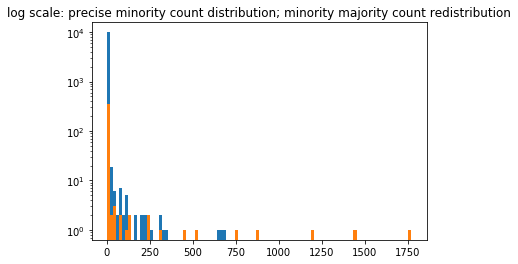

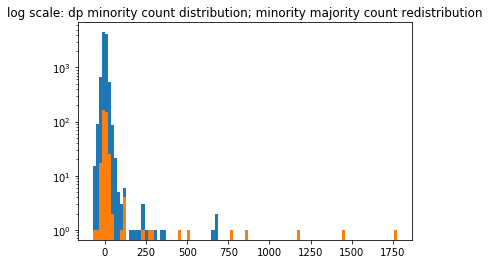

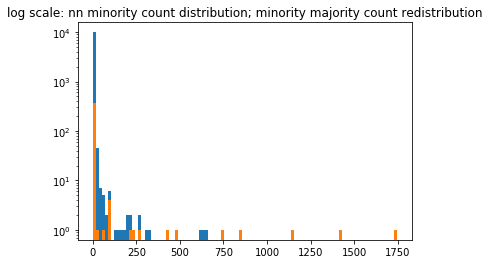

In [28]:
see_minmaj_distr(pop_3e5, version = "precise", use_log = True)
see_minmaj_distr(pop_3e5, version = "dp", use_log = True)
see_minmaj_distr(pop_3e5, version = "nn", use_log = True)

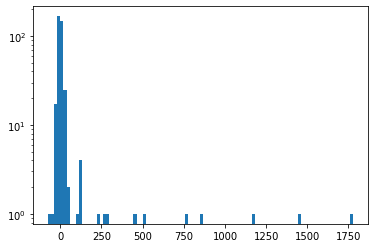

In [50]:
# mm, 0,1
# precise, 2,3
# dp, 4,5
# nn 6,7

plt.hist(pop_3e5[4][pop_3e5[0]], bins = 100, log = True)
plt.show()

In [39]:
np.percentile(pop_3e5[4], [.25,.5,.75,.98,.99999])

array([-49.0025, -43.    , -39.0075, -37.    , -37.    ])

In [49]:
np.quantile(pop_3e5[4], [.25,.50,.75,.98,.99,.999,.9999])

array([  -7.    ,    0.    ,    7.    ,   33.    ,   44.    ,  353.103 ,
       1446.0329])

In [58]:
def nonnegative_optimize_inv_weighted(imprecise_counts, control_total):
    """optimize the imprecise counts so that they sum to
    the control total and are non-negative
    
    Parameters
    ----------
    imprecise_counts : list-like of floats
    control_total : float
    
    Results
    -------
    returns optimized_counts, which are close to imprecise counts,
    but not negative, and match control total in aggregate
    """
    def f(x):
        k = np.quantile(imprecise_counts, .999)
        if x < k:
            return x**2
        else:
            return 2*(x**2)
        
    
    imprecise_counts = list(imprecise_counts)
    buffer = abs(min(imprecise_counts))+1
    
    model = ConcreteModel()
    model.I = range(len(imprecise_counts))
    model.x = Var(model.I, within=NonNegativeReals)
    model.objective = Objective(
        expr=sum(abs(1/(imprecise_counts[i]+buffer))*(model.x[i] - imprecise_counts[i])**2 for i in model.I))
    model.constraint = Constraint(
        expr=summation(model.x) == control_total)
    
    solver = SolverFactory('ipopt')
    results = solver.solve(model, options={'acceptable_tol':1e-4}, tee=False)
    optimized_counts = [value(model.x[i]) for i in model.I]
        
    return np.array(optimized_counts)

In [61]:
pop_3e5_inv_weight = main(nonnegative_optimize_inv_weighted, a=.02, b=10, pct_minority=.05, segregation_factor=1, K=10_000, N=3e5, epsilon=0.1, seed=1)
summaries(pop_3e5_inv_weight)

,minority majority totals,minority minority totals
precise,5649.000000,4190.000000
dp,5604.000000,3111.000000
non-neg,3974.531465,5864.468591
pct change,0.290769,-0.885075


In [62]:
pop_3e5 = main(nonnegative_optimize, a=.02, b=10, pct_minority=.05, segregation_factor=1, K=10_000, N=3e5, epsilon=0.1, seed=1)
summaries(pop_3e5)

,minority majority totals,minority minority totals
precise,5649.000000,4190.000000
dp,5604.000000,3111.000000
non-neg,4826.143845,5012.856245
pct change,0.138804,-0.611333
